# The Insulin Minimal Model

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

# Upload the data for this model
data = pd.read_csv('../Images_and_Data/Data/glucose_insulin.csv', 
                   index_col='time');

### The Insulin Model

In Chapter 17 I present the glucose minimal model; in Chapter 18 we implemented it using `run_simulation` and `run_solve_ivp`.
In this case study, we'll implement the other half of the Minimal Model, which describes the concentration of insulin.

In the insulin minimal model, the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

where $G(t)$ is the concentration of glucose at time $t$, and
$k$, $\gamma$, and $G_T$ are positive-valued parameters:

* $k$ controls the rate of insulin disappearance.

* $G_T$ determines the glucose threshold: when $G(t)$ exceeds this threshold, it causes insulin to appear; when $G(t)$ is below this threshold, it causes insulin to disappear.

* $\gamma$ controls how quickly insulin appears or disappears when the concentration of glucose is elevated or depressed.
 
Notice that this equation depends on time, $t$, since the initial injection.  It has the effect of increasing glucose sensitivity over time.  

In addition to the three parameters in the equation, we will also consider the initial concentration of insulin, $I_0$, to be a free parameter; that is, we will choose the value of $I_0$, and the other parameters, that best fit the data.

#### A Little Hint

As you implement this model, recognize that we will be following the same path that we followed in chapter 18 and in the "Glucose Minimal" case study.  In other words, you have a structure in place, so use cut-and-paste liberally.  

For each part of the implementation, you'll need to think about what has changed, and adapt your code to those changes.

#### Part 1

Write a version of `make_system` that takes the parameters of the model (`I0`, `k`, `gamma`, and `G_T`) as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_solve_ivp`.

Use it to make a `System` object with the parameters listed below.

Consider what has changed from the glucose model.  Before we used measured data about the insulin levels (`data.insulin`) to define `I` in update function (which you'll code in part 2).  Here, we want to use measured values of glucose to use in the update function.

For simplicity's sake, hard code `dt = 1` in the system made by `make_system`.

In [2]:
# Here are our initial parameters
I0 = 360   
k = 0.25
gamma = 0.005
G_T = 80

params = I0, k, gamma, G_T

In [6]:
# Define make_system

def make_system(params, data):
    I0, k, gamma, G_T = params
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    G = interpolate(data.glucose)
    
    init = pd.Series(dict(I=I0))
    
    return dict(init=init, params=params,
                  G=G,
                  t_0=t_0, t_end=t_end, dt=1)

In [7]:
# Create a system
system = make_system(params,data)

####  Part 2

Write a slope function that takes a time stamp, a `State` object, and a `System` object, and returns the derivative of `I` with respect to time.  Test your function with the initial conditions from `system`.

In this step, you are discretizing the differential equation--that is, you are finding the slope of the curve by evaluating the variable values at a discrete time step.

In [8]:
# Define the slope_function

def slope_func(t, state, system):
    I = state
    I0, k, gamma, G_T = system['params'] 
    G = system['G']
        
    dIdt = -k*I + gamma*(G(t) - G_T)*t
    
    return dIdt

In [10]:
# Test the function
dIdt = slope_func(0,system['init'],system)
dIdt

I   -90.0
dtype: float64

#### Part 3 

Run `run_solve_ivp` with your `System` object and slope function, and plot the results, along with the measured insulin levels.  Use the keyword argument `t_eval=data.index` so the results are evaluated as the same time stamps as the data.

`run_solve_ivp` takes takes the slope that is calculated by `slope_func`, and creates a curve out of it.  For each step, it finds the slope, and goes up or down at that rate until the next evaluation point.  

It would be like if someone gave you directions while you were blind-folded: "go 10 feet at an angle 30 degrees to the left... now go 15 feet at an angle 10 degrees to the right... etc..."   The path that you followed would be the function curve created by `run_solve_ivp`.  In doing so, it approximates a curve that solves the differential equation discretized by `slope_func`.

In [11]:
# Call run_solve_ivp
results, details = run_solve_ivp(system, slope_func,
                                  t_eval=data.index)
details

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 314
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x00000230F589ACD0>
   status: 0
  success: True
        t: array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  19,  22,  27,  32,
        42,  52,  62,  72,  82,  92, 102, 122, 142, 162, 182], dtype=int64)
 t_events: None
        y: array([[360.        , 219.90637007, 139.03445992,  91.81783375,
         64.87807847,  49.79677453,  41.87557233,  38.53062088,
         37.62029626,  39.00527365,  40.34798607,  42.51821556,
         42.2473803 ,  38.66557102,  30.74804676,  19.74590067,
          9.74133502,  -0.4454309 ,   0.76127436,   2.42542876,
          4.26977198,   5.53323372,  13.9911141 ,  32.13524982]])
 y_events: None

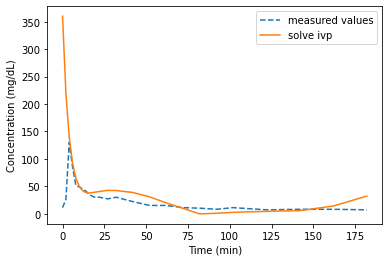

In [13]:
# Plot the results along with measured insulin
data.insulin.plot(style='--', label='measured values',
                 legend=True)
results.I.plot(style='-', label='solve ivp',color='C1',
               xlabel='Time (min)',
               ylabel='Concentration (mg/dL)',
              legend=True);

#### Part 4

Write an error function that takes a sequence of parameters as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, call `run_solve_ivp`, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it given parameters.

Hint: As we did with the glucose model, you might want to drop the first 2-3 elements from the sequence of errors.

In [14]:
# Write the error function

def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_solve_ivp(system, slope_func, 
                                     t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.I - data.insulin
    return errors.iloc[3:]

In [15]:
# Test the function
error_func(params,data)

6       6.817834
8      13.878078
10      0.796775
12     -3.124428
14     -2.469379
16      2.620296
19      9.005274
22     10.347986
27     15.518216
32     12.247380
42     16.665571
52     15.748047
62      4.745901
72     -1.258665
82    -10.445431
92     -7.238726
102    -8.574571
122    -2.730228
142    -2.466766
162     5.991114
182    25.135250
dtype: float64

#### Part 5

Use `leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

`leastsq` solves an optimization problem: it tries to minimize the difference between the curve created by the measured data and the curve created by the simulation.  In doing so, it defines the best parameters to make the model match the real world data.

In [16]:
# Use leastsq to find the best_params

best_params,fit_details = leastsq(error_func,params,data)
best_params

array([3.03860616e+02, 2.32070287e-01, 3.28924261e-03, 7.93491977e+01])

In [18]:
# Redefine params as best_params and rerun simulation
system['params'] = best_params

results2, details = run_solve_ivp(system, slope_func,
                                  t_eval=data.index)

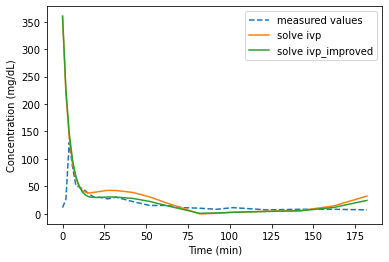

In [20]:
# Plot the results of both simulations along with measured insulin data
data.insulin.plot(style='--', label='measured values',
                  legend=True)
results.I.plot(style='-', label='solve ivp',color='C1',
               legend=True)
results2.I.plot(style='-', label='solve ivp_improved',color='C2',
                xlabel='Time (min)',
                ylabel='Concentration (mg/dL)',
               legend=True);

In [21]:
# Compare the errors

from numpy import sum

errors_orig = results.I - data.insulin
sum_orig =sum(errors_orig.iloc[3:]**2)

errors_lsq = results2.I - data.insulin
sum_lsq =sum(errors_lsq.iloc[3:]**2)

print(sum_orig,sum_lsq)

2307.526515535401 1174.5320132993395
